# IDS Bayesian Interferometry

In [1]:
from pymc3 import *
import numpy as np

In [2]:
def show_fft_image(img_fft):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
        
    img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    plt.show()

## Creating artificial data

In [39]:
size = 2
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
SIGMA = 5

I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
Cx = np.clip(Cx,0,255)
Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
Cy = np.clip(Cy,0,255)

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print 'min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI])

min I: 35.0 at (29,19)
max I: 157.0 at (30,32)



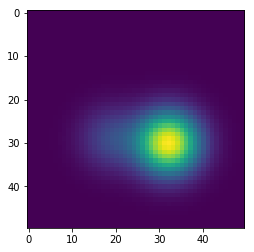

In [40]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.show()

img = Im_sinthc #rename variable

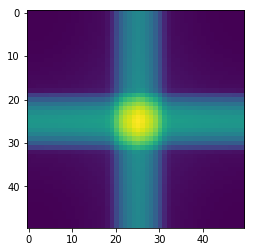

In [41]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

show_fft_image(np.log(img_fftabs+1e-12))

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

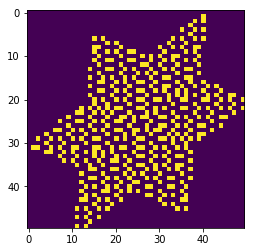

In [45]:
from masking import *

## Parameters
B_max = 1
antennas = 24
typeArray = 'VLA'
sigma = B_max/6

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

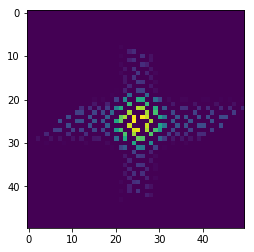

In [49]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+0.01)
show_fft_image(measurements_abs)


## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$

In [237]:
PI = np.pi
def PHI(U,l,Cx,Cy):
    print "U shape: %s, U type: %s\nl type: %s\nCx and Cy type: %s"%(U.shape, type(U), type(l), type(Cx))
    
    u = U[:,0]
    v = U[:,1]
    
    A = np.exp(-2.0 * PI * (u * u + v * v) * T.power(l,2))
    print "Amplitude shape: %s, Amplitude type: %s" %(A.shape, type(A))
    # argument = 2.0 * PI * (np.outer(u,Cx) + np.outer(v,Cy))
    argument = 2.0 * PI * (u[:,None]*Cx[None,:] + v[:,None]*Cy[None,:])
    print "argument shape: %s, argument type: %s" %(argument.shape, type(argument))
    
    cosPart = np.cos(argument)
    sinPart = np.sin(argument)
    
    print "cosPart shape: %s, cosPart type: %s" %(cosPart.shape, type(cosPart))

    RePart = T.dot(A,cosPart)
    ImPart = T.dot(A,sinPart)
    
    return RePart, ImPart

In [234]:
myU = np.ones((422,2))
myl = 0
myCx = np.array([[1,1]])
myCy = np.array([[1,1]])

PHI_Re, PHI_Im = PHI(myU,myl,myCx,myCy)
print T.sum(PHI_Re).eval(), T.sum(PHI_Im).eval()

U shape: (422, 2), U type: <type 'numpy.ndarray'>
l type: <type 'int'>
Cx and Cy type: <type 'numpy.ndarray'>
Amplitude shape: (422,), Amplitude type: <type 'numpy.ndarray'>
argument shape: (1, 422, 2), argument type: <type 'numpy.ndarray'>


AttributeError: 'tuple' object has no attribute 'eval'

In [247]:
numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = Model()

init_alpha = 128*np.ones(numberOfBasis)
init_Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cx = np.clip(Cx,0,255)
init_Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cy = np.clip(Cy,0,255)
init_sigma = np.random.randn(2,2)

with rbf_model:
    alpha_model = Normal('alpha', mu=init_alpha, sd=10, shape = numberOfBasis)
    Cx_model = Normal('Cx', mu=init_Cx, sd=10, shape = numberOfBasis)
    Cy_model = Normal('Cy', mu=init_Cy, sd=10, shape = numberOfBasis)
    l_model = HalfNormal('l', sd=1, shape = 1)
    sigma_model = Lognormal('sigma', np.zeros((2,2)), np.ones(2), shape=(2,2), testval=init_sigma)
#     a = Normal('a', mu=1, sd=10, shape = 1)
#     b = Normal('b', mu=1, sd=10, shape = 1)
#     c = Normal('c', mu=1, sd=10, shape = 1)
#     sigma_model.reshape((2,2))

    PHI_Re, PHI_Im = PHI(U,l_model,Cx_model,Cy_model)
    V_model = T.stack([T.sum(alpha_model*PHI_Re), T.sum(alpha_model*PHI_Im)])

    V_obs = MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    
    n_samples = 1000
    step = Metropolis()
    sample(n_samples, step)

U shape: (422, 2), U type: <type 'numpy.ndarray'>
l type: <class 'pymc3.model.TransformedRV'>
Cx and Cy type: <class 'pymc3.model.FreeRV'>
Amplitude shape: Shape.0, Amplitude type: <class 'theano.tensor.var.TensorVariable'>
argument shape: Shape.0, argument type: <class 'theano.tensor.var.TensorVariable'>
cosPart shape: Shape.0, cosPart type: <class 'theano.tensor.var.TensorVariable'>







  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Input dimension mis-match. (input[0].shape[0] = 422, input[1].shape[0] = 1)
Apply node that caused the error: Elemwise{Composite{exp((i0 * sqr(i1)))}}[(0, 1)](TensorConstant{[ -5.65486..18558e+04]}, ViewOp.0)
Toposort index: 11
Inputs types: [TensorType(float64, vector), TensorType(float64, vector)]
Inputs shapes: [(422,), (1,)]
Inputs strides: [(8,), (8,)]
Inputs values: ['not shown', array([ 0.79788456])]
Outputs clients: [[Gemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, Elemwise{Sin}[(0, 0)].0, Elemwise{Composite{exp((i0 * sqr(i1)))}}[(0, 1)].0, TensorConstant{0.0}), Gemv{no_inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, Elemwise{cos,no_inplace}.0, Elemwise{Composite{exp((i0 * sqr(i1)))}}[(0, 1)].0, TensorConstant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [245]:
init_sigma

array([[-1.14136806,  0.20079617],
       [-0.14299627, -0.38962499]])